# Test the sensitivity to the oxidative ratio

We test the sensitivity to the biospheric oxidative ratio by:

1. generating multiple values of ratios, using the expected value and uncertainty as mean and standard deviation,
2. calculating the APO timeseries with each value,
3. finding the standard deviation at each time step for all values.

We save the outputs to a netcdf file which contains uncertainties from all of our tests.

The final figure is produced in SensitivityStudy/Plot_all.ipynb

In [1]:
import os
import glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

from acrg.obs import get_obs
from acrg.name.name import open_ds

import apo_emiss_func, apo_funcs, apo_plot_info

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Inputs

In [10]:
year = 2015
month = 8
site = 'WAO'
sigma = 3

start_date = f'{year}-{str(month).zfill(2)}-01'
end_date = datetime(year, month, 1) + relativedelta(months=1, hours=-1)

oxidative_ratio_bio = -1.07
oxidative_ratio_bio_uncertainty = 0.04
number = 1e3

ocean_o2_model = 'nemo'

file_ident = {'bc': 'bc',
              'ff': 'ff',
              'ocean': 'ocean'}

fontsize = 16

date_str = f'{year}{str(month).zfill(2)}'

## Get the timeseries data

Get the pre-run forward model for each component

In [11]:
timeseries_data_year = apo_funcs.get_timeseries(sites=[site], year=year, sources=['ff', 'ocean', 'bc'])[site]
timeseries_data = timeseries_data_year.sel(time=slice(start_date, end_date))

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc']
---------------------------



### Plot the components

In [24]:
colors = {'gpp-bio': 'forestgreen', 'ff': 'darkorange', 'ocean': 'dodgerblue', 'rtot-bio': 'fuchsia'}
dash = {'o2': None, 'co2': 'dash', 'n2': 'dot'}

fig = go.Figure()

[fig.add_trace(go.Scatter(
 x = timeseries_data.time,
 y = timeseries_data[source],
 name = " ".join(source.split("_")),
 line = dict(color=colors[source.split('_')[1]], dash=dash[source.split('_')[0]])
 ))
 for source in timeseries_data.data_vars if 'bc' not in source]  

fig.update_layout(yaxis_title = 'mf, ppm',
                  margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

fig.show()

## Get the obs

In [12]:
apo_all = {'obs': {'ts': get_obs(['WAO'], 'apo', start_date, end_date, keep_missing=True)['WAO'][0].mf,
                   'color': 'magenta'}
           }

Assuming status flag = 0 for all sites
Getting apo data for WAO...
... changing species from apo to APO
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20230213.nc
... slicing from 2015-08-01 00:00:00 to 2015-08-31 22:59:59.999999999


## Calculate APO

Calculate APO using the expected value for the oxidative ratio

In [13]:
sim_color = {'ecco': 'dodgerblue', 'nemo': 'navy'}

apo_model = {sim: apo_emiss_func.apo(ocean_o2 = timeseries_data[f'o2_ocean_{sim}'],
                                     ff_co2 = timeseries_data.co2_ff,
                                     ocean_co2 = timeseries_data[f'co2_ocean_{sim}'],
                                     ocean_n2 = timeseries_data.n2_ocean_nemo,
                                     ff_o2 = timeseries_data.o2_ff,
                                     oxidative_ratio_bio = oxidative_ratio_bio,
                                     mf_o2 = 1/6.04,
                                     convert = False) + timeseries_data.apo_adjusted_bc
             for sim in sim_color.keys()}

for sim, color in sim_color.items():
    apo_all[f'model, {sim}'] = {'ts': apo_model[sim], 'color': color}

fig = go.Figure()
[fig.add_trace(go.Scatter(
    x = ts['ts'].time,
    y = ts['ts'],
    name = name,
    line = dict(color=ts['color'])
))
  for name, ts in apo_all.items()]

fig.update_layout(yaxis_title = 'mf, per meg',
                  margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

fig.show()

## Vary the oxidative ratio

Calculate an APO timeseries using varying values for the biospheric oxidative ratio

- produce a normally distributed set of random values of oxidative ratio,
- calculate the total APO model for each value.

In [14]:
oxidative_ratios_bio = np.random.normal(loc = oxidative_ratio_bio,
                                        scale = oxidative_ratio_bio_uncertainty,
                                        size = int(number))

apo_test = np.zeros((int(number), int(len(timeseries_data['co2_ff'].time))))
apo_diff = np.zeros_like(apo_test)

for oo, ox_ratio in enumerate(oxidative_ratios_bio):
    apo_test[oo,:] = apo_emiss_func.apo(ff_co2 = timeseries_data['co2_ff'],
                                        ocean_co2 = timeseries_data[f'co2_ocean_{ocean_o2_model}'],
                                        ocean_o2 = timeseries_data[f'o2_ocean_{ocean_o2_model}'],
                                        ocean_n2 = timeseries_data['n2_ocean_nemo'],
                                        ff_o2 = timeseries_data['o2_ff'],
                                        oxidative_ratio_bio = ox_ratio,
                                        mf_o2 = 1/6.04,
                                        convert = False)
    apo_diff[oo,:] = apo_model[ocean_o2_model] - apo_test[oo]

if number<20:
    fig = go.Figure()
    [fig.add_trace(go.Scatter(
        x = ts.time,
        y = ts,
        name = oxidative_ratios_bio[number]
        ))
    for number, ts in apo_diff.items()]

    fig.update_layout(yaxis_title = 'mf, per meg',
                      margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

    fig.show()

## See what it looks like

Calculate the standard deviation from all of the runs, and plot onto the APO timeseries calculated earlier

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


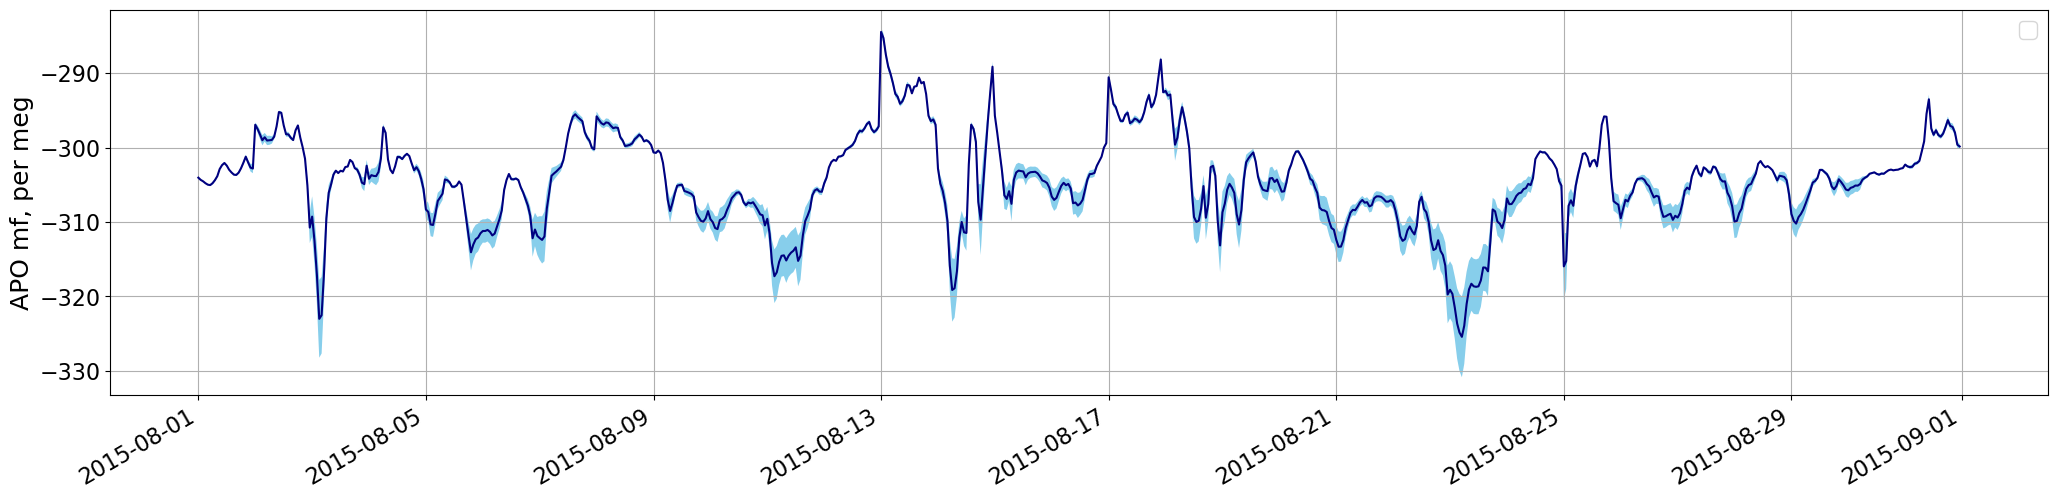

In [15]:
# calculate the standard deviation
apo_uncertainty = xr.DataArray(data = apo_test.std(axis=0),
                               coords = {'time': timeseries_data.time},
                               dims = ['time'])

# multiply by the number of sigma specified above
apo_uncertainty_sigma = sigma * apo_uncertainty

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
# plot the uncertainty as shading
unc_plot = plt.fill_between(apo_model[ocean_o2_model].time,
                            apo_model[ocean_o2_model] - apo_uncertainty_sigma,
                            apo_model[ocean_o2_model] + apo_uncertainty_sigma,
                            facecolor='skyblue')
# plot the APO model
apo_model_bc = apo_model[ocean_o2_model]
apo_plot = apo_model_bc.plot(ax=ax, color='navy')

grid = ax.grid()
legend = ax.legend(loc='best', fontsize=fontsize)
xlab = ax.set_xlabel('')
ylab = ax.set_ylabel('APO mf, per meg', fontsize=fontsize+2)
ticks = ax.tick_params(labelsize=fontsize)

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_ORbio_sensitivity_{sigma}sigma_{date_str}.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Save to netcdf

We save the uncertainty to a netcdf file.

This file contains the uncertainty from our range of tests.

In [8]:
update_model = True

In [9]:
# get the uncertainties file
uncertainty_filename = os.path.join('/user', 'work', 'vf20487', 'Sensitivities', f'APO_uncertainties_{date_str}.nc')

# define the attributes to add to the bio oxidative ratio uncertainty variable
attrs = {'units': 'per meg',
         'sigma': 1,
         'description': 'uncertainty associate with the biospheric oxidative ratio',
         'distribution mean': oxidative_ratio_bio,
         'distribution standard deviation': oxidative_ratio_bio_uncertainty,
         'Monte Carlo number of runs': number}

if os.path.isfile(uncertainty_filename):
    # if the file already exists then open it and update the variable
    print(f'Opening uncertainty file to update OR bio uncertainty variable')
    print(uncertainty_filename)
    apo_uncertainty_ds = open_ds(uncertainty_filename)
    apo_uncertainty_ds[f'OR_bio_{ocean_o2_model}'] = apo_uncertainty
else:
    # if the file doesn't exist, convert the uncertainty to a dataset
    print(f'Saving OR bio uncertainty to file: {uncertainty_filename}')
    apo_uncertainty_ds = apo_uncertainty.to_dataset(name=f'OR_bio_{ocean_o2_model}')

# update the variable attributes
apo_uncertainty_ds[f'OR_bio_{ocean_o2_model}'] = apo_uncertainty_ds[f'OR_bio_{ocean_o2_model}'].assign_attrs(attrs)

# the file also contains timeseries for the APO models which we can update here
if f'model_{ocean_o2_model}' not in apo_uncertainty_ds.data_vars or update_model:
    attrs_model = {'units': 'per meg',
                   'ocean o2 model': ocean_o2_model}
    apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_model[ocean_o2_model]
    apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_uncertainty_ds[f'model_{ocean_o2_model}'].assign_attrs(attrs_model)

# save to netcdf
apo_uncertainty_ds.to_netcdf(uncertainty_filename)

Opening uncertainty file to update OR bio uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201512.nc
